# Esplanade dataset
readme

In [1]:
%matplotlib widget

import os
import cedalion
import cedalion.nirs
import cedalion.sigproc.quality as quality

import cedalion.sigproc.motion_correct as motion_correct
import cedalion.models.glm as glm

import xarray as xr
import matplotlib.pyplot as p
import cedalion.plots as plots
from cedalion import units
import numpy as np
import pandas as pd
from math import ceil

import gzip
import pickle
import json


from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list, fcluster
from scipy.spatial.distance import squareform
from scipy import signal
from scipy.stats import pearsonr



# import my own functions from a different directory
# SHANNON: Change this to the path where you have the processingFuncs_DAB.py file
import sys
sys.path.append('/Users/dboas/Documents/GitHub/cedalion-dab-funcs')
import DABfuncs_load_and_preprocess as pfDAB
import DABfuncs_plot_DQR as pfDAB_dqr

# Turn off all warnings
import warnings
warnings.filterwarnings('ignore')

In [76]:
import importlib
importlib.reload(pfDAB_dqr)

<module 'DABfuncs_plot_DQR' from '/Users/dboas/Documents/GitHub/cedalion-dab-funcs/DABfuncs_plot_DQR.py'>

# Initialize root directory, files and parameters

In [2]:
# root directory for the BIDS dataset
rootDir_data = '/Users/dboas/Documents/People/2024/BoasDavid/NN22_Data/Datasets/Esplanade/'

# subject and file IDs to process
subj_ids = ['01','02','03','04','05','06','07','08','09']
file_ids = ['STS_run-01']

# pruning parameters
snr_thresh = 5 # the SNR (std/mean) of a channel. 
sd_threshs = [1, 60]*units.mm # defines the lower and upper bounds for the source-detector separation that we would like to keep
amp_threshs = [1e-5, 0.89] # define whether a channel's amplitude is within a certain range

# motion correction parameters
flag_do_splineSG = False # if True, will do splineSG motion correction

# band pass filter parameters applied to OD after motion correction
fmin = 0.02 * units.Hz
fmax = 3 * units.Hz

# list of stim trial_types to include...
stim_lst_dqr = ['ST'] # for DQR plots
stim_lst_hrf = ['ST'] # for calculating HRFs





# determine the number of subjects and files. Often used in loops.
n_subjects = len(subj_ids)
n_files_per_subject = len(file_ids)

# Load and Pre-Process

Loading 1 of 9 subjects, 1 of 1 files : sub-01_task-STS_run-01_nirs
Loading 2 of 9 subjects, 1 of 1 files : sub-02_task-STS_run-01_nirs
Loading 3 of 9 subjects, 1 of 1 files : sub-03_task-STS_run-01_nirs
Loading 4 of 9 subjects, 1 of 1 files : sub-04_task-STS_run-01_nirs
Loading 5 of 9 subjects, 1 of 1 files : sub-05_task-STS_run-01_nirs
Loading 6 of 9 subjects, 1 of 1 files : sub-06_task-STS_run-01_nirs
Loading 7 of 9 subjects, 1 of 1 files : sub-07_task-STS_run-01_nirs
Loading 8 of 9 subjects, 1 of 1 files : sub-08_task-STS_run-01_nirs
Loading 9 of 9 subjects, 1 of 1 files : sub-09_task-STS_run-01_nirs


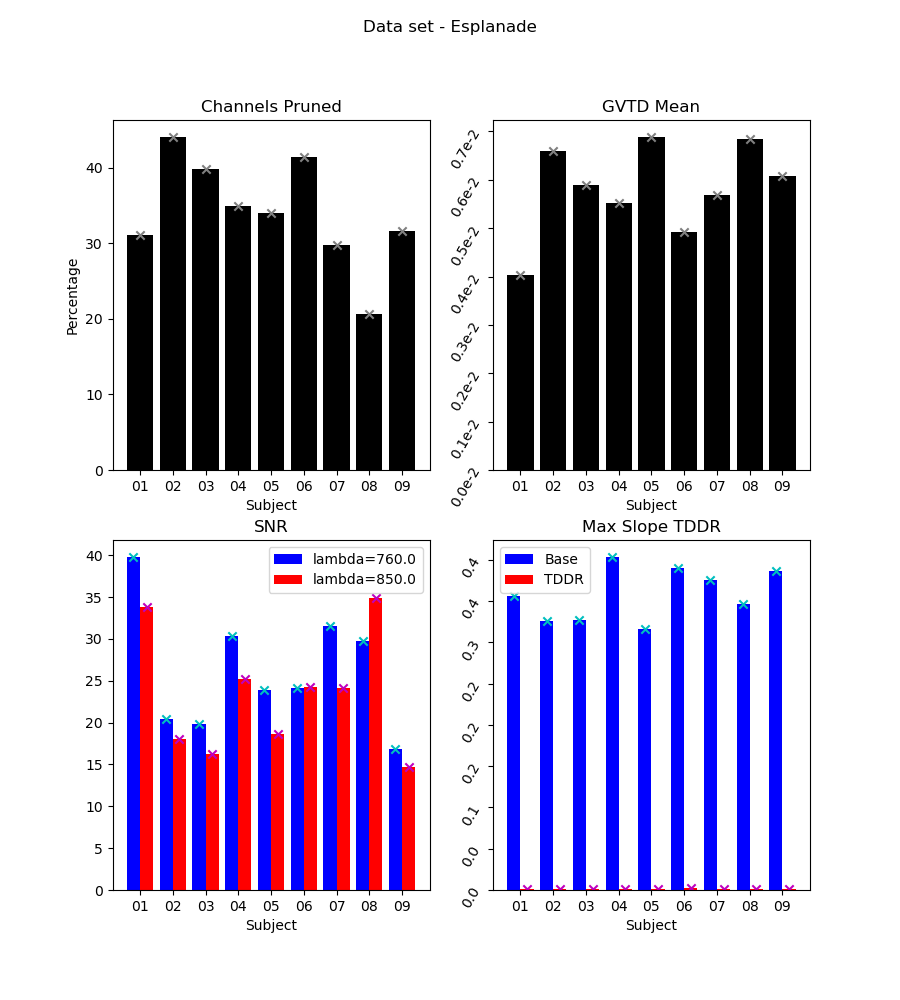

In [3]:
# Load and preprocess the data
#
# This function will load all the data for the specified subject and file IDs, and preprocess the data.
# This function will also create several data quality report (DQR) figures that are saved in /derivatives/plots.
# The function will return the preprocessed data and a list of the filenames that were loaded, both as 
# two dimensional lists [subj_idx][file_idx].
# The data is returned as a recording container with the following fields:
#   timeseries - the data matrices with dimensions of ('channel', 'wavelength', 'time') 
#      or ('channel', 'HbO/HbR', 'time') depending on the data type. 
#      The following sub-fields are included:
#         'amp' - the original amplitude data slightly processed to remove negative and NaN values and to 
#            apply a 3 point median filter to remove outliers.
#         'amp_pruned' - the 'amp' data pruned according to the SNR, SD, and amplitude thresholds.
#         'od' - the optical density data
#         'od_tddr' - the optical density data after TDDR motion correction is applied
#         'conc_tddr' - the concentration data obtained from 'od_tddr'
#         'od_splineSG' and 'conc_splineSG' - returned if splineSG motion correction is applied (i.e. flag_do_splineSG=True)
#   stim - the stimulus data with 'onset', 'duration', and 'trial_type' fields and more from the events.tsv files.
#   aux_ts - the auxiliary time series data from the SNIRF files.
#      In addition, the following aux sub-fields are added during pre-processing:
#         'gvtd' - the global variance of the time derivative of the 'od' data.
#         'gvtd_tddr' - the global variance of the time derivative of the 'od_tddr' data.

rec, filenm_lst = pfDAB.load_and_preprocess( rootDir_data, subj_ids, file_ids, snr_thresh, sd_threshs, amp_threshs, stim_lst_dqr, flag_do_splineSG, fmin, fmax )

## Produce motion artifact DQR
This is optional. It shows the number of motion artifacts identifed per channel after TDDR on a scalp plot. It also shows the fraction of channels that have a motion artifact versus time and stores this in rec.aux_ts['tInc_all_tddr'] so you can view it with vis_time_series.py. It also plots the GVTD after TDDR so you can consider that along with tInc_all when identify time periods to mask.

In [4]:
rec = pfDAB_dqr.plot_tIncCh_dqr( rec, rootDir_data, filenm_lst )

## Save one run to a pickle file for viewing with vis_time_series.py

In [7]:
# Save the rec object to a pickle file so you can view it with vis_time_series.py
# save one file from one subject at a time.
# this is saved in the derivatives/processed_data directory.
subj_idx = 0
file_idx = 0

file_path_pkl = os.path.join(rootDir_data, 'derivatives', 'processed_data', 'rec.pkl.gz')
file = gzip.GzipFile(file_path_pkl, 'wb')
file.write(pickle.dumps(rec[subj_idx][file_idx]))
file.close()     

# HRF group average

## GLM with SSR

In [5]:
trange_hrf = [5, 35] * units.s # time range for block averaging
trange_hrf_stat = [5, 20] # time range for t-stat

ssr_rho_thresh = 15 * units.mm
glm_basis_func_param = 1*units.s
glm_drift_order = 4

stim_lst_hrf = ['ST'] # for calculating HRFs

flag_do_GLM = False # if True, will do GLM analysis, otherwise does block average
                    # The GLM doesn't presently handle any NaN's it seems. But 
                    # pruned channels have NaN's.. curious.


# loop over subjects and files
for subj_idx in range( n_subjects ):
    for file_idx in range( n_files_per_subject ):

        filenm = filenm_lst[subj_idx][file_idx]

        print( f"Running {subj_idx+1} of {n_subjects} subjects : {filenm}" )

        if flag_do_splineSG:
            TS = rec[subj_idx][file_idx]['conc_splineSG'].copy().stack(measurement = ['channel', 'chromo']).sortby('chromo')
            conc_filt = rec[subj_idx][file_idx]['conc_splineSG'].copy()
        else:
            TS = rec[subj_idx][file_idx]['conc_tddr'].copy().stack(measurement = ['channel', 'chromo']).sortby('chromo')
            conc_filt = rec[subj_idx][file_idx]['conc_tddr'].copy()

        #
        # GLM
        #

        # select the stim for the given file
        stim = rec[subj_idx][file_idx].stim.copy()

        # Do GLM or Block Average
        # Right now the GLM doesn't handle NaN's, but pruned channels have NaN's.. curious.
        if not flag_do_GLM:
            # do block average
            pred_hrf = conc_filt

        else:
            # do the GLM

            # get the short separation channels
            ts_long, ts_short = cedalion.nirs.split_long_short_channels(
                conc_filt, rec[subj_idx][file_idx].geo3d, distance_threshold=ssr_rho_thresh
            )

            # if stim has a column named 'amplitude' then rename it to 'value'
            # I noticed that some events files have 'amplitude' and some have 'value' and some have neither
            if 'amplitude' in stim.columns:
                stim = stim.rename(columns={"amplitude": "value"})
            elif 'amplitude' not in stim.columns and 'value' not in stim.columns:
                stim['value'] = 1

            # make the design matrix
            # ’closest’: Use the closest short channel 
            # ‘max_corr’: Use the short channel with the highest correlation 
            # ‘mean’: Use the average of all short channels.
            dm, channel_wise_regressors = glm.make_design_matrix(
                conc_filt,
                ts_short,
                stim[stim.trial_type.isin(stim_lst_hrf)],
                rec[subj_idx][file_idx].geo3d,
                basis_function = glm.GaussianKernels(trange_hrf[0], trange_hrf[1], t_delta=glm_basis_func_param, t_std=glm_basis_func_param), 
                drift_order = glm_drift_order, 
                short_channel_method='mean'
            )

            # fit the GLM model
            betas = glm.fit(conc_filt, dm, channel_wise_regressors, noise_model="ols")

            # prediction of all HRF regressors, i.e. all regressors that start with 'HRF '
            pred_hrf = glm.predict(
                conc_filt,
                betas.sel(regressor=betas.regressor.str.startswith("HRF ")),
                dm,
                channel_wise_regressors
            )

        # get the HRF prediction 
        # This is a simple way to get HRF stats by getting epochs and then simple block average, 
        # but it will not work for event related designs with overlapping epochs.
        # In the future we will have to update glm.predict to provide HRF stats.
        pred_hrf = pred_hrf.transpose('chromo', 'channel', 'time')
        pred_hrf = pred_hrf.assign_coords(samples=('time', np.arange(len(pred_hrf.time))))
        pred_hrf['time'] = pred_hrf.time.pint.quantify(units.s)     
        pred_hrf['source'] = conc_filt.source
        pred_hrf['detector'] = conc_filt.detector

        conc_epochs_tmp = pred_hrf.cd.to_epochs(
                                    stim,  # stimulus dataframe
                                    set(stim.trial_type),  # select events
                                    before=trange_hrf[0],  # seconds before stimulus
                                    after=trange_hrf[1],  # seconds after stimulus
                                )

        # concatenate the different epochs from each file for each subject
        if file_idx == 0:
            conc_epochs_all = conc_epochs_tmp
        else:
            conc_epochs_all = xr.concat([conc_epochs_all, conc_epochs_tmp], dim='epoch')

        # DONE LOOP OVER FILES

    # Block Average
    baseline_conc = conc_epochs_all.sel(reltime=(conc_epochs_all.reltime < 0)).mean('reltime')
    conc_epochs = conc_epochs_all - baseline_conc
    blockaverage = conc_epochs.groupby('trial_type').mean('epoch')

    # gather the blockaverage across subjects
    if subj_idx == 0:
        blockaverage_subj = np.zeros((blockaverage.values.shape[0], blockaverage.values.shape[1], blockaverage.values.shape[2], blockaverage.values.shape[3], n_subjects)) 
        blockaverage_subj[:,:,:,:,0] = blockaverage
    else:
        blockaverage_subj[:,:,:,:,subj_idx] = blockaverage

    # DONE LOOP OVER SUBJECTS


# Save the block average data to a pickle file
# this can then be viewed with vis_plot_probe_from_pickle.py
# The file is saved in derivates/processed_data/blockaverage.pkl.gz
blockaverage_subj_mean = np.nanmean(blockaverage_subj, axis=4)
blockaverage.values = blockaverage_subj_mean
file_path_pkl = os.path.join(rootDir_data, 'derivatives', 'processed_data', 'blockaverage.pkl.gz')
file = gzip.GzipFile(file_path_pkl, 'wb')
file.write(pickle.dumps([blockaverage, rec[subj_idx][file_idx].geo2d, rec[subj_idx][file_idx].geo3d]))
file.close()     

print('Saved group average HRF to ' + file_path_pkl)



Running 1 of 9 subjects : sub-01_task-STS_run-01_nirs
Running 2 of 9 subjects : sub-02_task-STS_run-01_nirs
Running 3 of 9 subjects : sub-03_task-STS_run-01_nirs
Running 4 of 9 subjects : sub-04_task-STS_run-01_nirs
Running 5 of 9 subjects : sub-05_task-STS_run-01_nirs
Running 6 of 9 subjects : sub-06_task-STS_run-01_nirs
Running 7 of 9 subjects : sub-07_task-STS_run-01_nirs
Running 8 of 9 subjects : sub-08_task-STS_run-01_nirs
Running 9 of 9 subjects : sub-09_task-STS_run-01_nirs
Saved group average HRF to /Users/dboas/Documents/People/2024/BoasDavid/NN22_Data/Datasets/Esplanade/derivatives/processed_data/blockaverage.pkl.gz


## Scalp plot the group average

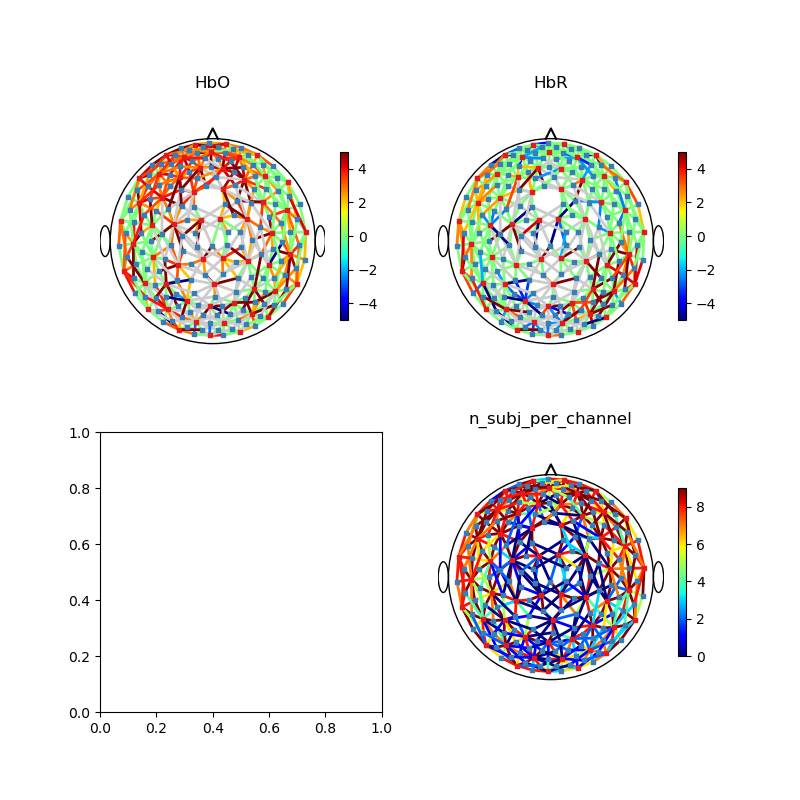

In [6]:
trial_str = ['ST']

max_val = 5 

# save the average across subjects
blockaverage_subj_mean = np.nanmean(blockaverage_subj, axis=4)
blockaverage_subj_std = np.nanstd(blockaverage_subj, axis=4)

# how many columns have ~NaN
foo = np.squeeze(np.mean(blockaverage_subj[0,0,:,:,:], axis=1))
n_subj_per_channel = np.sum(~np.isnan(foo), axis=1)
n_subj_per_channel = n_subj_per_channel[:,np.newaxis] @ np.ones((1,blockaverage_subj_std.shape[0]))
n_subj_per_channel = n_subj_per_channel[:,:,np.newaxis] @ np.ones((1,blockaverage_subj_std.shape[1]))
n_subj_per_channel = n_subj_per_channel[:,:,:,np.newaxis] @ np.ones((1,blockaverage_subj_std.shape[3]))
n_subj_per_channel = n_subj_per_channel.transpose(1,2,0,3)
# put n_subj_per_channel into an xarray
n_subj_per_channel_xr = xr.DataArray(
    n_subj_per_channel,
    dims=["trial_type","chromo","channel", "reltime"],
    coords={"trial_type": blockaverage.trial_type, "chromo": blockaverage.chromo, "channel": blockaverage.channel, "reltime": blockaverage.reltime}
)

blockaverage_subj_tstat = blockaverage_subj_mean / (blockaverage_subj_std / np.sqrt(blockaverage_subj.shape[4]))

blockaverage_tstat = blockaverage.copy()
blockaverage_tstat.values = blockaverage_subj_tstat

# put the values of blockaverage_subj_mean into blockaverage2
blockaverage.values = blockaverage_subj_mean


# scalp plot the mean evoked response
f, ax = p.subplots(2, 2, figsize=(8, 8))

evoked_conc = blockaverage_tstat.sel(trial_type=trial_str, chromo='HbO', reltime=(blockaverage.reltime > trange_hrf_stat[0]) & (blockaverage.reltime < trange_hrf_stat[1])).mean("reltime")
# set values of evoked_conc to zero where the t-stat is less than 2
evoked_conc.values[np.abs(evoked_conc.values) < 2] = 0
plots.scalp_plot(
        rec[0][0]['conc_tddr'],
        rec[0][0].geo3d,
        evoked_conc,
        ax[0][0],
        cmap='jet',
        optode_labels=False,
        optode_size=5,
        vmin=-max_val,
        vmax=max_val,
        title='HbO'
    )

evoked_conc = blockaverage_tstat.sel(trial_type=trial_str, chromo='HbR', reltime=(blockaverage.reltime > trange_hrf_stat[0]) & (blockaverage.reltime < trange_hrf_stat[1])).mean("reltime")
# set values of evoked_conc to zero where the t-stat is less than 2
evoked_conc.values[np.abs(evoked_conc.values) < 2] = 0
plots.scalp_plot(
        rec[0][0]['conc_tddr'],
        rec[0][0].geo3d,
        evoked_conc,
        ax[0][1],
        cmap='jet',
        optode_labels=False,
        optode_size=5,
        vmin=-max_val,
        vmax=max_val,
        title='HbR'
    )

# scalp plot n_subj_per_channel
plots.scalp_plot(
        rec[0][0]['conc_tddr'],
        rec[0][0].geo3d,
        n_subj_per_channel_xr.sel(trial_type=trial_str,chromo='HbO', reltime=0),
        ax[1][1],
        cmap='jet',
        optode_labels=False,
        optode_size=5,
        vmin=0,
        vmax=n_subjects,
        title="n_subj_per_channel"
    )

